In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

import pickle

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeterministicCNNSingleFC(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [B, 3, 64, 64]
        x = self.pool(F.relu(self.conv1(x)))  # → [B, 32, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # → [B, 64, 16, 16]
        x = self.gap(x)                       # → [B, 64, 1, 1]
        x = x.view(x.size(0), -1)             # → [B, 64]
        logits = self.fc1(x)                  # → [B, num_classes]
        return logits


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Convolutional layers with increased channels
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers with dropout
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: [B, 3, 64, 64]
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # → [B, 64, 32, 32]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # → [B, 128, 16, 16]
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # → [B, 256, 8, 8]

        x = self.gap(x)                                 # → [B, 256, 1, 1]
        x = x.view(x.size(0), -1)                       # → [B, 256]

        x = F.relu(self.fc1(x))                         # → [B, 128]
        x = self.dropout(x)
        logits = self.fc2(x)                            # → [B, num_classes]
        return logits


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [5]:
def load_data(batch_size=64):  # Changed from 54 to 64 to match deterministic CNN
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    # Use fixed random seed for reproducible splits
    #torch.manual_seed(42)
    #train_size = int(0.8 * len(dataset))
    #test_size = len(dataset) - train_size
    #train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    with open('datasplit/split_indices.pkl', 'rb') as f:
        split = pickle.load(f)
        train_dataset = Subset(dataset, split['train'])
        test_dataset = Subset(dataset, split['test'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [6]:
# train the CNN model in 10 epoch
def train_cnn(model, train_loader, num_epochs=10):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    print("Training complete.")

# Evaluate the CNN model
def evaluate_cnn(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [7]:
model_cnn = EnhancedCNN(num_classes=10).to(device)
train_loader, test_loader = load_data(batch_size=54)  # Use batch size of 64 for CNN
train_cnn(model_cnn, train_loader, num_epochs=10)
accuracy = evaluate_cnn(model_cnn, test_loader)

Epoch [1/10], Loss: 1.0092
Epoch [2/10], Loss: 0.7223
Epoch [3/10], Loss: 0.6563
Epoch [4/10], Loss: 0.5681
Epoch [5/10], Loss: 0.5116
Epoch [6/10], Loss: 0.4813
Epoch [7/10], Loss: 0.4168
Epoch [8/10], Loss: 0.3913
Epoch [9/10], Loss: 0.3623
Epoch [10/10], Loss: 0.3518
Training complete.
Test Accuracy: 78.33%


In [8]:
# print the model weights' and bias' mean and std for each layer, save it into a dict and print the dict

weight_stats = {}
for name, param in model_cnn.named_parameters():
    if 'weight' in name or 'bias' in name:
        weight_stats[name] = {
            'mean': param.data.mean().item(),
            'std': param.data.std().item()
        }

In [9]:
weight_stats

{'conv1.weight': {'mean': -0.005621904972940683, 'std': 0.09282386302947998},
 'conv1.bias': {'mean': 0.014988880604505539, 'std': 0.061341192573308945},
 'bn1.weight': {'mean': 0.9594166278839111, 'std': 0.14433902502059937},
 'bn1.bias': {'mean': -0.07501769065856934, 'std': 0.12681561708450317},
 'conv2.weight': {'mean': -0.006636498030275106, 'std': 0.05868689715862274},
 'conv2.bias': {'mean': 8.482334669679403e-05, 'std': 0.015298276208341122},
 'bn2.weight': {'mean': 0.9540426731109619, 'std': 0.09453348070383072},
 'bn2.bias': {'mean': -0.2683653235435486, 'std': 0.10673338174819946},
 'conv3.weight': {'mean': -0.0004870542325079441, 'std': 0.05603499710559845},
 'conv3.bias': {'mean': 0.0006833263905718923, 'std': 0.017254481092095375},
 'bn3.weight': {'mean': 1.0595515966415405, 'std': 0.04845123365521431},
 'bn3.bias': {'mean': -0.13420388102531433, 'std': 0.07363780587911606},
 'fc1.weight': {'mean': -0.0066662076860666275, 'std': 0.0758756771683693},
 'fc1.bias': {'mean': 

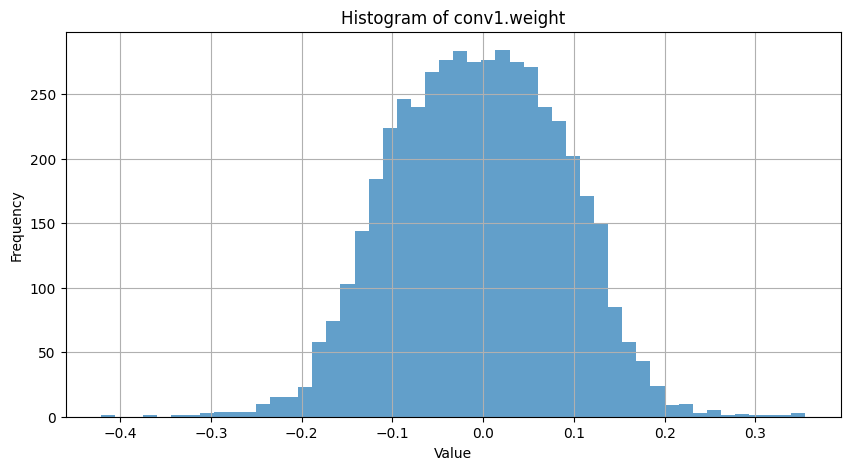

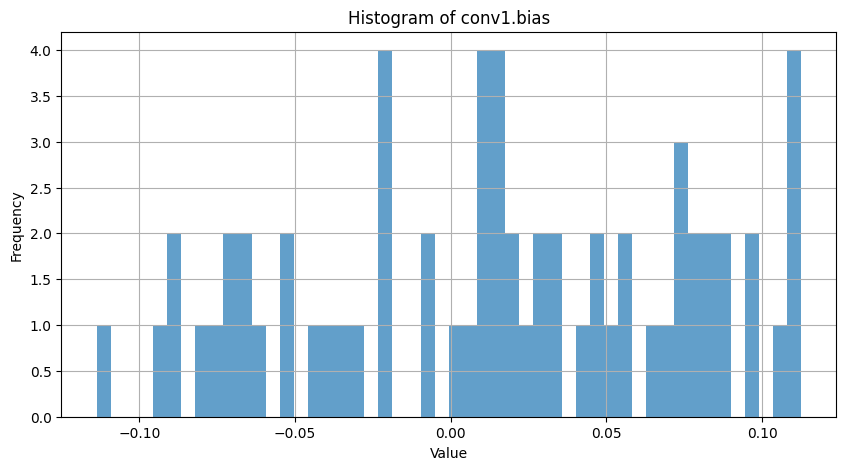

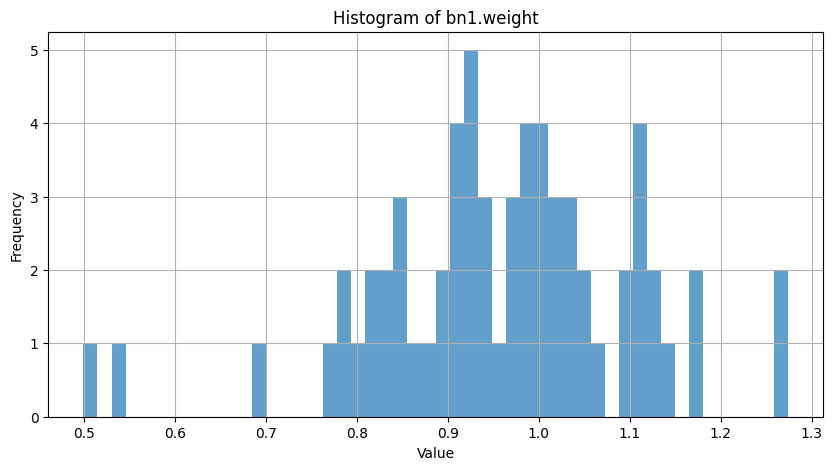

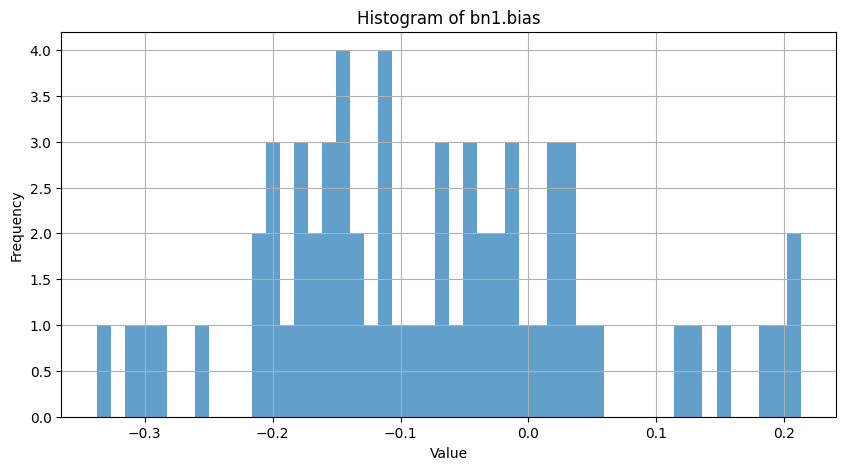

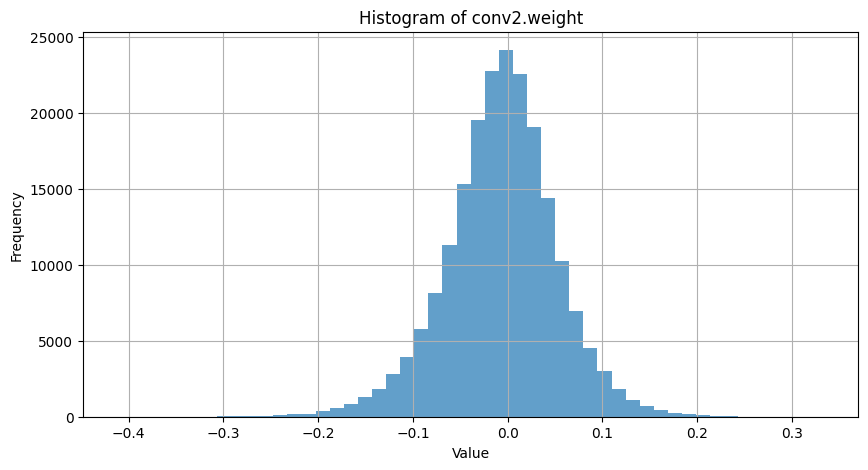

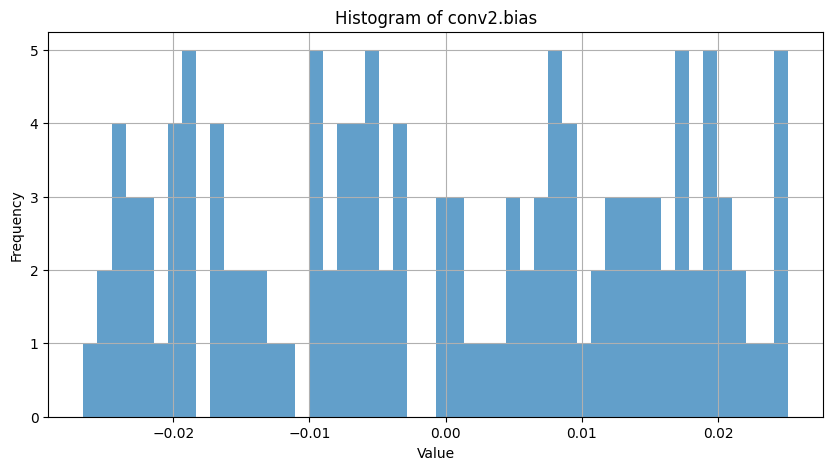

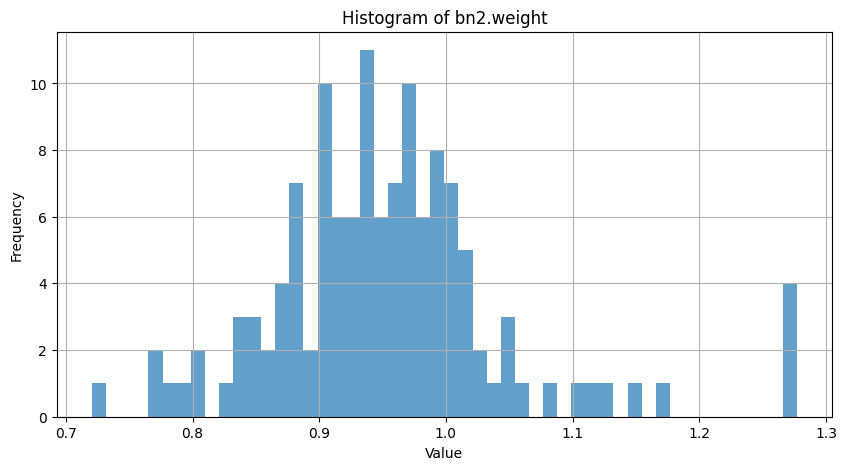

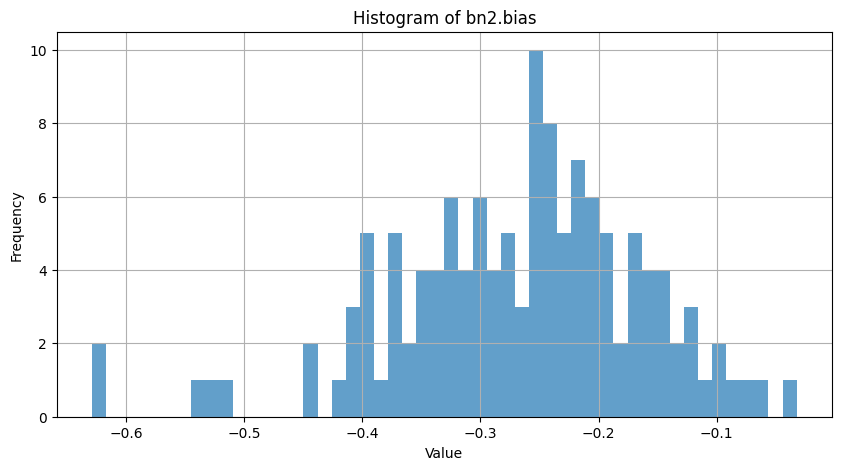

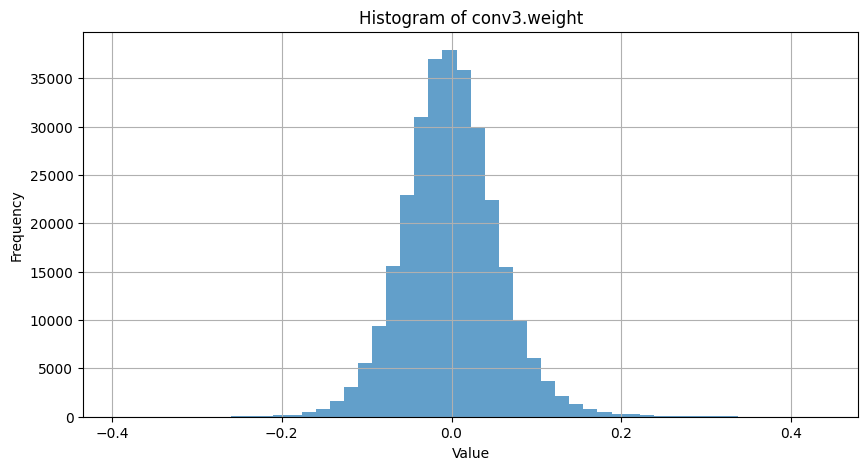

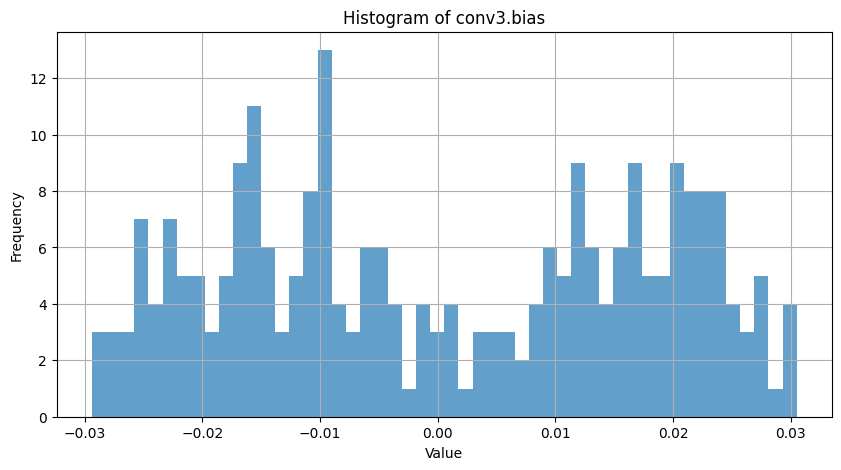

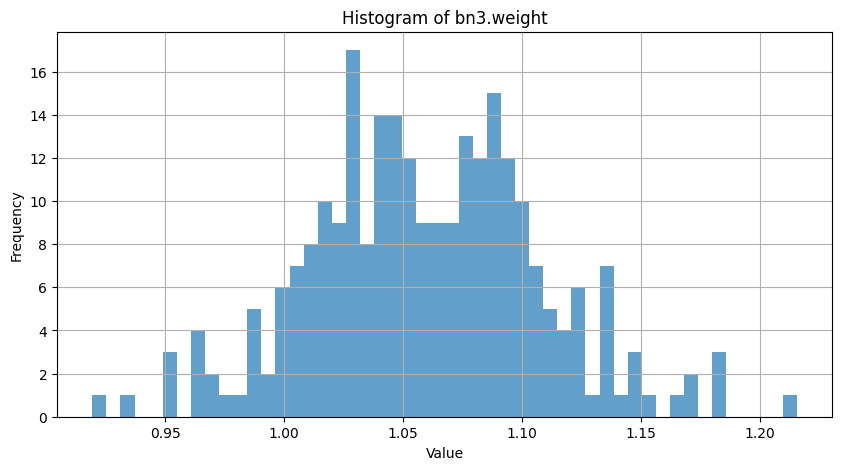

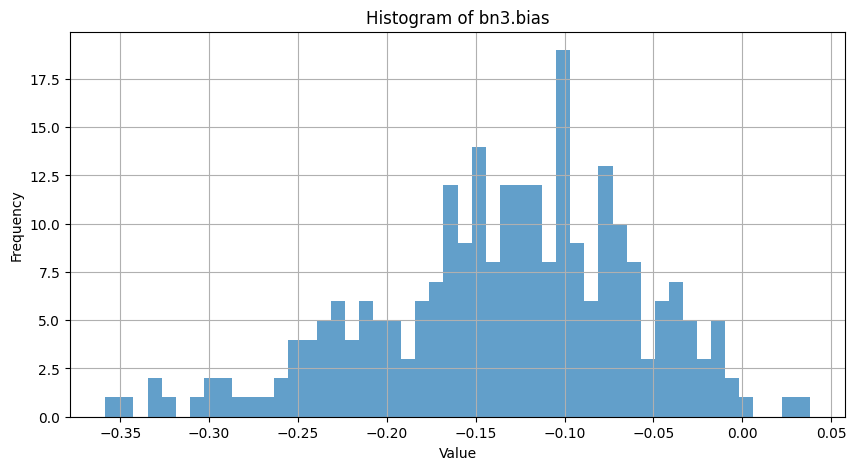

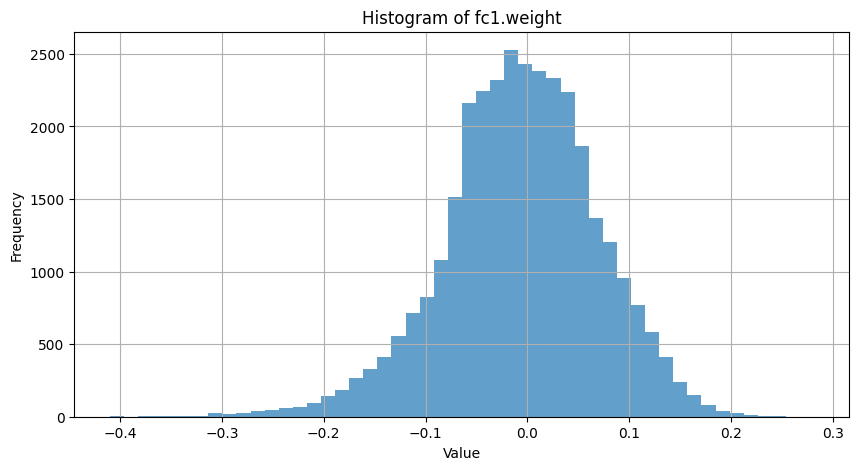

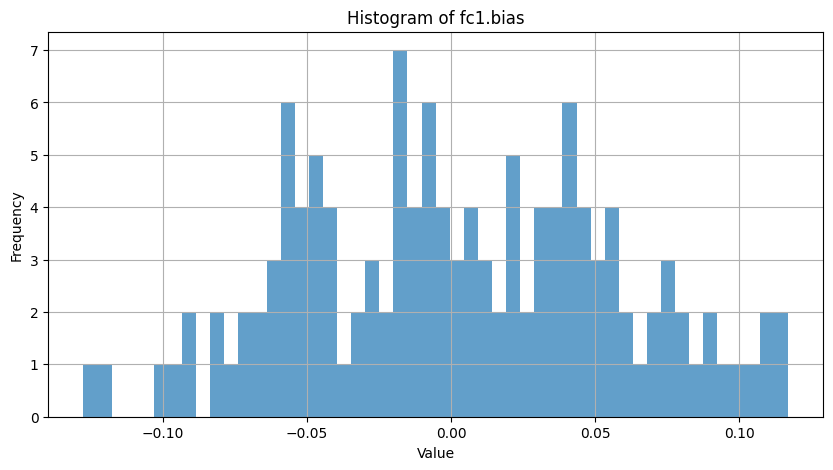

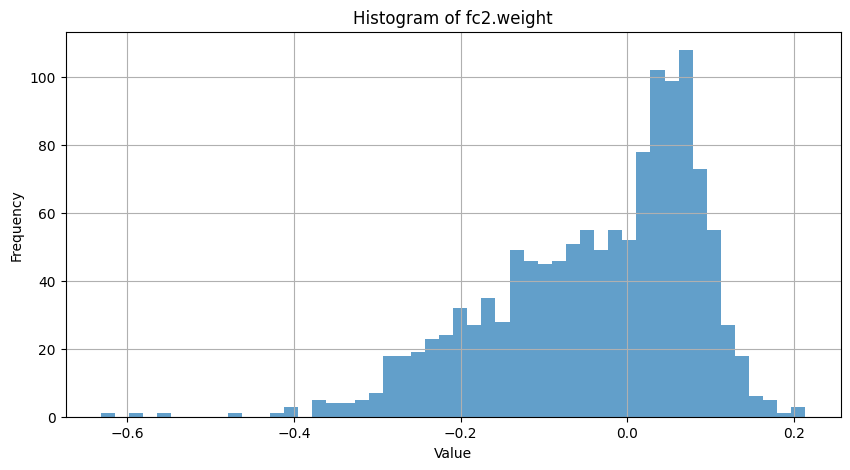

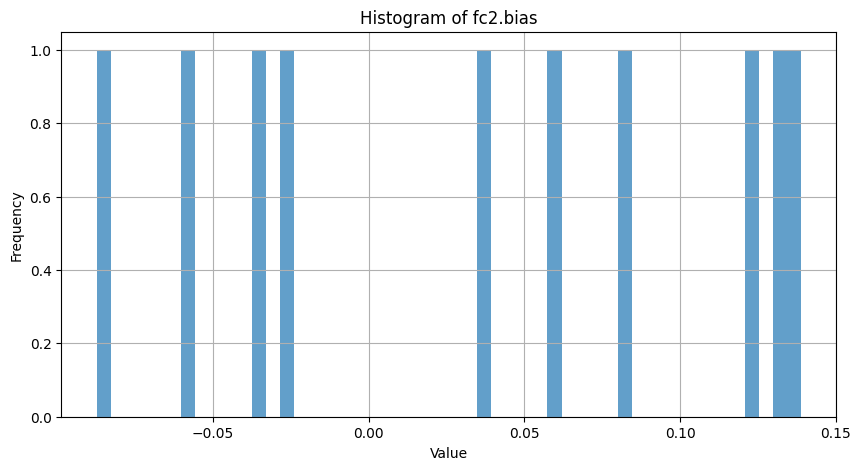

In [10]:
# plot the histogram of the weights and biases
for name, param in model_cnn.named_parameters():
    if 'weight' in name or 'bias' in name:
        plt.figure(figsize=(10, 5))
        plt.hist(param.data.cpu().numpy().flatten(), bins=50, alpha=0.7)
        plt.title(f'Histogram of {name}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid()
        plt.show()